<SBML: test_1>
<roadrunner.RoadRunner() { 
'this' : 0x44a54a0
'modelLoaded' : true
'modelName' : test_1
'libSBMLVersion' : LibSBML Version: 5.11.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x476cbf0, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 10
}>, 
'integrator' : 
< roadrunner.Integrator() >

}>
--------------------------------------------------------------------------------
cvode
('relative_tolerance', ':', 1e-06)
('absolute_tolerance', ':', 1.5624999999999998e-20)
('stiff', ':', True)
('maximum_bdf_order', ':', 5)
('maximum_adams_order', ':', 12)
('maximum_num_steps', ':', 20000)
('maximum_time_step', ':', 0.0)
('minimum_time_step', ':', 0.0)
('initial_time_step', ':', 0.0)
('multiple_steps', ':', False)
('variable_step_size', ':', False)


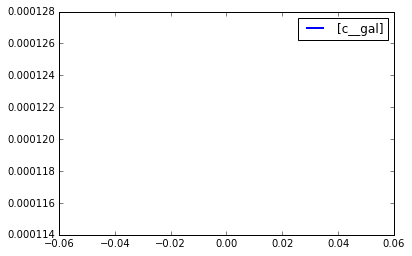

In [6]:
%matplotlib inline

# Simulating simple test model
import roadrunner
reload(roadrunner)

from simapp.models import CompModel

mtest = CompModel.objects.get(model_id="test_1")
print(mtest)

r = roadrunner.RoadRunner(mtest.filepath)
# settings
absTol = 1E-6
relTol = 1E-6
absTol = absTol * min(r.model.getCompartmentVolumes())  # absTol relative to the amounts
integrator = r.getIntegrator()
integrator.setValue('stiff', True)
integrator.setValue('absolute_tolerance', absTol)
integrator.setValue('relative_tolerance', relTol)

# integrate
r.simulate(0,10)
print(r)
print('-'*80)
integrator = r.getIntegrator()
print(integrator.getName())
for key in integrator.getSettings():
    print(key, ':', integrator.getValue(key))
# plot

r.plot()

In [8]:
print(r.getSimulationData())

    time, [c__gal]
 [[    0,  0.00012]]

